In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler    
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file = '/content/drive/My Drive/criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

n_campaigns = 400

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

FileNotFoundError: ignored

# New Section

Time decay

In [0]:
def time_decay_attribution(df):

    
    def count_by_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def discount_by_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            for i in range(campaign_id + 1):
                
                counters[i] =  2*((campaign_id-i)/campaign_id)
        return counters
                
                             
    campaign_impressions = count_by_campaign(df)       
    
    dfc = df[df['conversion'] == 1]
    
    idx = dfc.groupby(['jid'])['timestamp_norm'].transform(max) == dfc['timestamp_norm']
    campaign_conversions = discount_by_campaign(dfc[idx])
        
    return campaign_conversions / campaign_impressions

tda = time_decay_attribution(df6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [0]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

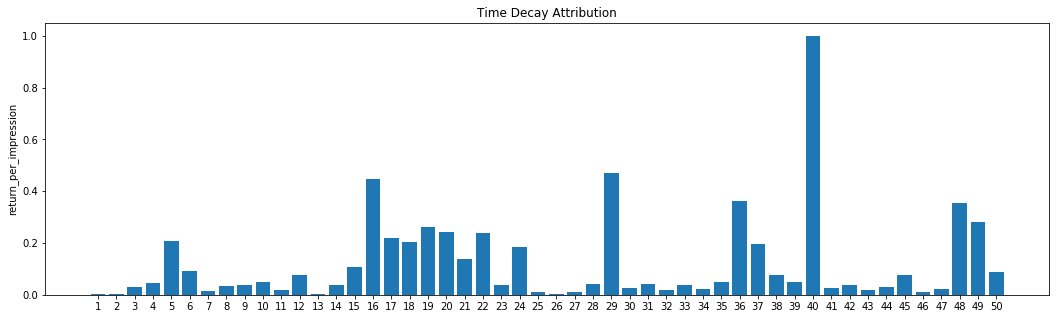

In [0]:
tda_normed = NormalizeData(tda)
campaign_ids = list(range(1,51))
y_pos = np.arange(len(campaign_ids))
return_per_impression = tda_normed[:50]

f, ax = plt.subplots(figsize=(18,5))
plt.bar(y_pos, return_per_impression, align='center', alpha=1)
plt.xticks(y_pos, campaign_ids)



)
plt.title('Time Decay Attribution')
plt.show()

In [0]:
def U_shape_attribution(df):
    #Assuming u score to be 1 as max and 0.5 as min 
    u_score_max = 1
    u_score_min = 0.5
    def count_by_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def ushape_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            for i in range(campaign_id):
                if i == 0: 
                    counters[i] += u_score_max  
                elif i == campaign_id:
                    counters[i] += u_score_max 
                else:
                    counters[i] += u_score_min  
        return counters 
                
    campaign_impressions = count_by_campaign(df)       
    
    dfc = df[df['conversion'] == 1]
    
    idx = dfc.groupby(['jid'])['timestamp_norm'].transform(max) == dfc['timestamp_norm']
    campaign_conversions = ushape_campaign(dfc[idx])
        
    return campaign_conversions / campaign_impressions

usa = U_shape_attribution(df6)

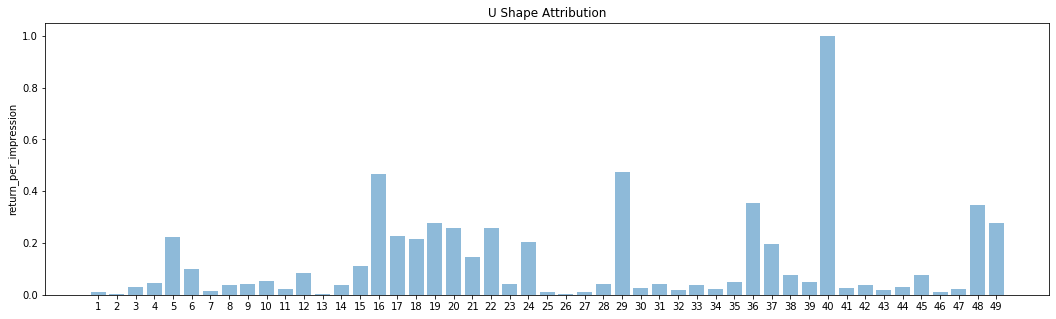

In [0]:
usa_normed =NormalizeData(usa)
campaign_ids = list(range(1,50))
y_pos = np.arange(len(campaign_ids))
return_per_impression = usa_normed[:49]

f, ax = plt.subplots(figsize=(18,5))
plt.bar(y_pos, return_per_impression, align='center', alpha=0.5)
plt.xticks(y_pos, campaign_ids)
plt.ylabel('return_per_impression')
plt.title('U Shape Attribution')

plt.show()

In [0]:
def Linear_attribution(df):
    # Assuming the linear score to be 1 for normalized effect
    linear_score = 1
    def count_by_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def linear_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            for i in range(campaign_id+1):
                #counters[i] += (linear_score/campaign_id)
                counters[i] += 1  
    # Adding 1 to all campaigns leading up to conversion. 
        return counters
                
    campaign_impressions = count_by_campaign(df)       
    
    dfc = df[df['conversion'] == 1]
    
    idx = dfc.groupby(['jid'])['timestamp_norm'].transform(max) == dfc['timestamp_norm']
    campaign_conversions = linear_campaign(dfc[idx])
        
    return campaign_conversions / campaign_impressions

la = Linear_attribution(df6)

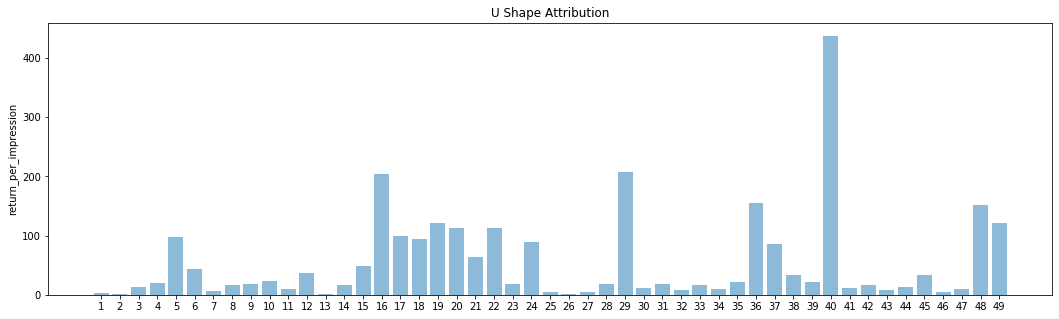

In [0]:



la_normed =NormalizeData(la)
campaign_ids = list(range(1,50))
y_pos = np.arange(len(campaign_ids))
return_per_impression = la[:49]

f, ax = plt.subplots(figsize=(18,5))
plt.bar(y_pos, return_per_impression, align='center', alpha=0.5)
plt.xticks(y_pos, campaign_ids)
plt.ylabel('return_per_impression')
plt.title('U Shape Attribution')

plt.show()


In [0]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)

    df_converted = df[df['conversion'] == 1]

    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    
    campaign_conversions = count_by_campaign(df_converted[idx])
    
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

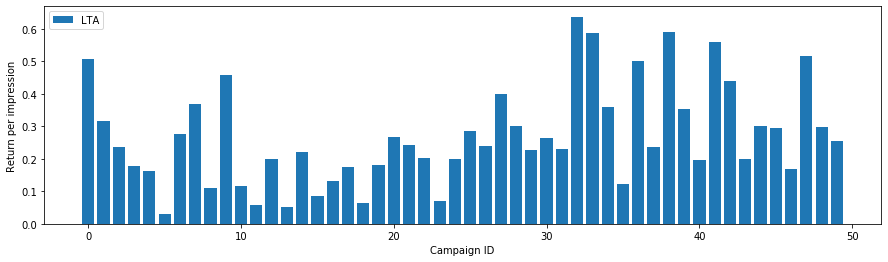

In [0]:
# Visualization of the attribution scores
lta_normal = NormalizeData(lta)
campaign_idx = list(range(1,51))
y_pos = np.arange(len(campaign_idx))
return_per_impression = lta_normal[:50]

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( y_pos, return_per_impression, label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [0]:
conv= df6[(df6['conversion']==1)]


In [0]:
array = conv['uid'].unique()

In [0]:
df7 = pd.DataFrame(data=array, columns=["uid_unique"])

In [0]:
all=df6['uid'].nunique()

In [0]:
df8=df6.copy()

In [0]:
cond = df8['uid'].isin(df7['uid_unique']) == False
df8.drop(df8[cond].index, inplace = True)

In [0]:
df8.shape

(325465, 27)

In [0]:
df6.shape

(597829, 27)

In [0]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df.copy()
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)

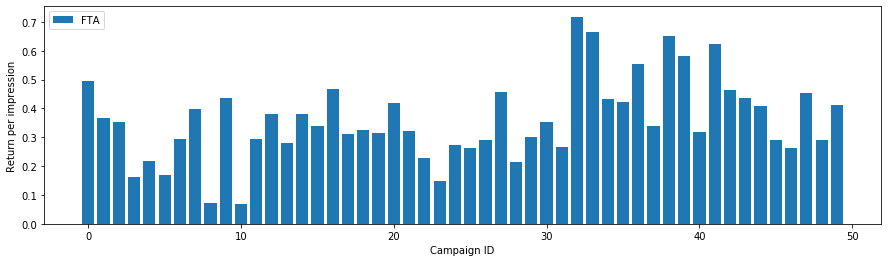

In [0]:
# Visualization of the attribution scores
fta_normal = NormalizeData(fta)
campaign_idx = list(range(1,51))
y_pos = np.arange(len(campaign_idx))
return_per_impression = fta_normal[:50]

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( y_pos, return_per_impression, label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [0]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [0]:

def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])


In [0]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta,fta,usa,la,tda]
pitch_list = []
j_list =[]
reward_list = []
for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        pitch_list.append(pitch)
        j_list.append(j)
        reward_list.append(reward)
        print('{} {} : {}'.format(pitch, j, reward))

0.1 0 : 1231
0.1 1 : 1210
0.1 2 : 1480
0.1 3 : 1396
0.1 4 : 1209
0.25 0 : 1083
0.25 1 : 1160
0.25 2 : 1244
0.25 3 : 1190
0.25 4 : 874
0.5 0 : 654
0.5 1 : 1070
0.5 2 : 254
0.5 3 : 280
0.5 4 : 297
1.0 0 : 297
1.0 1 : 599
1.0 2 : 361
1.0 3 : 361
1.0 4 : 392
1.5 0 : 358
1.5 1 : 249
1.5 2 : 411
1.5 3 : 410
1.5 4 : 409
2.0 0 : 409
2.0 1 : 290
2.0 2 : 351
2.0 3 : 353
2.0 4 : 348
2.5 0 : 442
2.5 1 : 321
2.5 2 : 315
2.5 3 : 316
2.5 4 : 321
3.0 0 : 476
3.0 1 : 349
3.0 2 : 229
3.0 3 : 230
3.0 4 : 237


[1231,1210,1480,1396,1209,1083,1160,1244,1190,874,654,1070,254,280,297,297,599,361,361,392,358,249,411,410,409,409,290,351,353,348,442,321,315,316,321,476,349,229,230,237]

In [0]:
reward_list= [1231,1210,1480,1396,1209,1083,1160,1244,1190,874,654,1070,254,280,297,297,599,361,361,392,358,249,411,410,409,409,290,351,353,348,442,321,315,316,321,476,349,229,230,237]

In [0]:
print(len(reward_list))

40


In [0]:
print(pitch_list)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.5, 2.5, 2.5, 2.5, 2.5, 3.0, 3.0, 3.0, 3.0, 3.0]


In [0]:
pitch_list=np.array([0.1,0.25,0.5,1.0,1.5,2.0,2.5,3.0])


In [0]:
lta_list=[]
fta_list=[]
usa_list=[]
la_list=[]
tda_list=[]
i = 0
while i < len(reward_list):

  lta_list.append(reward_list[i])
  fta_list.append(reward_list[i+1])
  usa_list.append(reward_list[i+2])
  la_list.append(reward_list[i+3])
  tda_list.append(reward_list[i+4])
  i = i+ 5




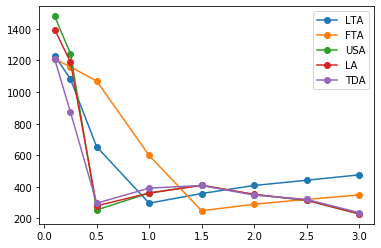

In [0]:
a=[lta_list,fta_list,usa_list,la_list,tda_list]
b=['LTA','FTA','USA','LA','TDA']

for i, j in zip(a, b):
  plt.plot(pitch_list, i,marker='o',label=j)
#plt.plot(pitch_list, fta_list,marker='o',label='FTA')
#plt.plot(pitch_list, usa_list,marker='o',label='USA')
plt.legend()
plt.show()